This code generates capytaine data by creating a bicylindrical configuration with two cylinder meshes (separated my some minimal distance so they don't overlap).

Pros: Less likely to have unforseen errors since this is close to Capytaine's typical usage. Does not support arbitrary cylinder amount but could be extended.

Cons: Has covered panels that, at best, increase computation time (bad for high-resolution meshes), and at worst cause inaccurate computations (although not likely). Additionally, it cannot support configurations that are not a stack of cylinders (cross section has indents).

In [1]:
import capytaine as cpt
import numpy as np
import matplotlib.pyplot as plt
import time

# removes capytaine warnings from clogging outputs
import logging
logging.getLogger("capytaine").setLevel(logging.ERROR)

In [2]:
# creates two full cylinders, separated by a minimal distance

solver = cpt.BEMSolver()

def showBemCompoundCylinder(a1,a2,d1,d2,resolution):
  body2 = cpt.meshes.predefined.mesh_vertical_cylinder(radius= a2,center=(0,0,0),length = d2,faces_max_radius=resolution*a2)
  body1 = cpt.meshes.predefined.mesh_vertical_cylinder(radius=a1,center=(0,0,0),length = d1-d2,faces_max_radius=resolution*a2)
  body1 = body1.translated([0,0,-d2-0.001])
  

  body = body1 + body2
  body = cpt.FloatingBody(body)
  body.add_translation_dof(name='Heave')
  body = body.immersed_part()
  body.show_matplotlib()


def bemCompoundCylinder(h,a1,a2,d1,d2,resolution, w):
  body2 = cpt.meshes.predefined.mesh_vertical_cylinder(radius= a2,center=(0,0,0),length = d2,faces_max_radius=resolution*a2)
  body1 = cpt.meshes.predefined.mesh_vertical_cylinder(radius=a1,center=(0,0,0),length = d1-d2,faces_max_radius=resolution*a2)
  body1 = body1.translated([0,0,-d2-0.00001])

  body = body1 + body2
  body = cpt.FloatingBody(body)
  body.add_translation_dof(name='Heave')
  body = body.immersed_part()
  #body.show_matplotlib()
  faces_centers = body.mesh.faces_centers

  rad_problem = cpt.RadiationProblem(body=body,
                                        wavenumber = w, water_depth=h)
  results = solver.solve(rad_problem, keep_details = True, )
  dataset = cpt.assemble_dataset([results])
  
  w = 1
  rho = 1023 # density of our special material
  wave_amp = 1
  g = 9.81
  omega = np.sqrt(w*np.tanh(w*h)*g)

  A = np.array(dataset['added_mass'])
  B = np.array(dataset['radiation_damping'])
  A_nondim = h**3 / (rho * np.pi * a2**3) * A
  B_nondim = h**3 / (omega * rho * np.pi * a2**3) * B
  return A,B, A_nondim, B_nondim, body.mesh.nb_faces

def timeit(h,a1,a2,d1,d2, res,iter):
  def oneRun(res):
    start_time = time.time()
    result = bemCompoundCylinder(h,a1,a2,d1,d2,res)
    end_time = time.time()
    return end_time-start_time
  avg_time = np.mean([oneRun(res) for i in range(iter)])
  return avg_time

# avg_time = timeit(resolution,100)#default resolution

# print(f"Execution time: {avg_time} seconds") #run more than once ..second time is the actual runtime that excludes compile time


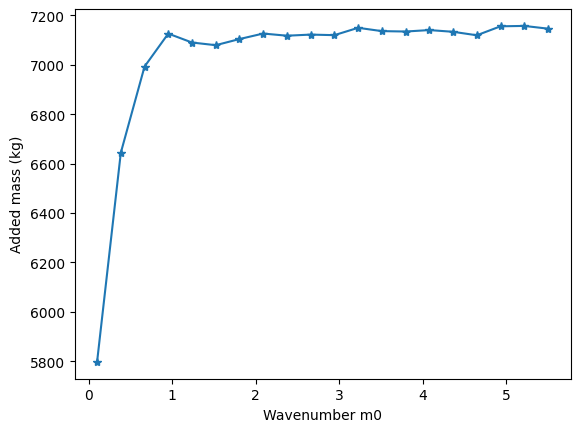

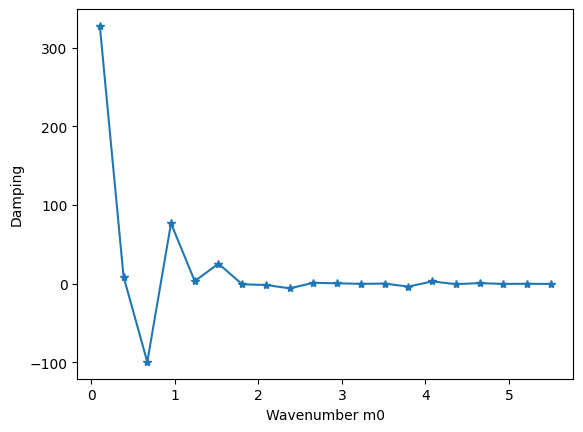

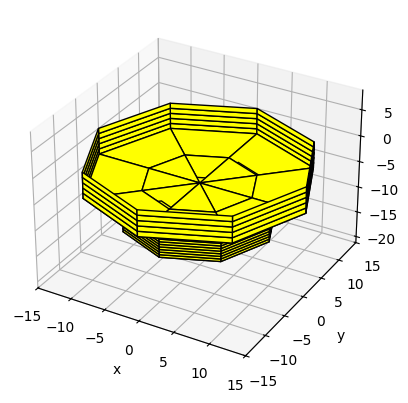

In [ ]:
# Mini Bicylinder
# h = 1.05
# a1 = 0.5
# a2 = 1
# d1 = 0.5
# d2 = 0.25
# resolution = 30

# # Small Bicylinder
# h = 20.0
# a1 = 5.0
# a2 = 10.0
# d1 = 10.0
# d2 = 5.0
# resolution = 30

# Big Bicylinder
h = 25.0
a1 = 10.0
a2 = 15.0
d1 = 15.0
d2 = 10.0
resolution = 30

m0_nums = np.linspace(0.1, 5.5, 20)
results = [bemCompoundCylinder(h,a1,a2,d1,d2,resolution, w) for w in m0_nums]

A_nondim = [res[2].flatten() for res in results]
B_nondim = [res[3].flatten() for res in results]

plt.figure()
plt.plot(m0_nums,A_nondim, '*-')
plt.xlabel("Wavenumber m0")
plt.ylabel("Added mass (kg)")
plt.show()


plt.figure()
plt.plot(m0_nums,B_nondim, '*-')
plt.xlabel("Wavenumber m0")
plt.ylabel("Damping")
plt.show()

showBemCompoundCylinder(a1,a2,d1,d2,resolution)

# Damping is evidently inaccurate for low wavenumbers

In [ ]:
# times = [timeit(res,10) for res in resolutions]

# plt.figure()
# plt.plot(npanels,times,'*-')
# plt.xlabel("Panels (N)")
# plt.ylabel("Time(s)")
# plt.show()
